# Portfolio Analysis and Visualization Script
**Data Analyst Portfolio Project - Investment Performance Analysis**

In [5]:
pip install -r requirements_analyst.txt

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.3.2 -> 25.2
[notice] To update, run: C:\Program Files\Python312\python.exe -m pip install --upgrade pip


In [21]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import mysql.connector
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# Set visualization style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

In [22]:
try:
    conn = mysql.connector.connect(
        host="localhost",
        user="root",     # change if you use another username
        password="root"  # put your MySQL password
    )
    if conn.is_connected():
        print("✅ Connection successful!")
    conn.close()
except Exception as e:
    print("❌ Connection failed:", e)

db_config = {
    'host': 'localhost',
    'user': 'root',
    'password': 'root',
    'database': 'portfolio_analysis'
}

✅ Connection successful!


In [23]:
%run data_fetcher.ipynb

2025-09-26 03:31:36,138 - INFO - Successfully connected to MySQL database
2025-09-26 03:31:36,140 - INFO - Updating data for 8 stocks...
2025-09-26 03:31:36,140 - INFO - Fetching data for AAPL...
2025-09-26 03:31:36,500 - INFO - Available columns for AAPL: ['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'Dividends', 'Stock Splits', 'Symbol']
2025-09-26 03:31:36,501 - WARNING - Adj Close not found for AAPL, using Close price
2025-09-26 03:31:36,504 - INFO - Successfully fetched 127 records for AAPL
2025-09-26 03:31:36,532 - INFO - Successfully stored 127 records for AAPL
2025-09-26 03:31:37,534 - INFO - Fetching data for AMZN...
2025-09-26 03:31:37,706 - INFO - Available columns for AMZN: ['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'Dividends', 'Stock Splits', 'Symbol']
2025-09-26 03:31:37,710 - WARNING - Adj Close not found for AMZN, using Close price
2025-09-26 03:31:37,714 - INFO - Successfully fetched 127 records for AMZN
2025-09-26 03:31:37,759 - INFO - Successfully store

In [50]:
class PortfolioAnalyzer:
    def __init__(self, db_config):
        """Initialize with database configuration"""
        self.db_config = db_config
        self.connection = None
        
    def connect_to_db(self):
        """Establish database connection"""
        try:
            self.connection = mysql.connector.connect(**self.db_config)
            print("✅ Connected to MySQL database")
            return True
        except mysql.connector.Error as e:
            print(f"❌ Error connecting to MySQL: {e}")
            return False
    
    def close_connection(self):
        """Close database connection"""
        if self.connection:
            self.connection.close()
            print("🔌 Database connection closed")
    
    def load_stock_data(self, days=180):
        """Load stock price data from database"""
        query = """
            SELECT symbol, date, close_price, volume
            FROM stock_prices 
            WHERE date >= DATE_SUB(CURDATE(), INTERVAL %s DAY)
            ORDER BY symbol, date
        """
        
        df = pd.read_sql(query, self.connection, params=[days])
        df['date'] = pd.to_datetime(df['date'])
        return df
    
    def load_portfolio_data(self):
        """Load portfolio and holdings data"""
        query = """
            SELECT 
                p.id as portfolio_id,
                p.name as portfolio_name,
                p.description,
                ph.symbol,
                ph.quantity,
                ph.purchase_price,
                ph.purchase_date,
                s.name as stock_name,
                s.sector
            FROM portfolios p
            JOIN portfolio_holdings ph ON p.id = ph.portfolio_id
            JOIN stocks s ON ph.symbol = s.symbol
            ORDER BY p.id, ph.symbol
        """
        
        return pd.read_sql(query, self.connection)
    
    def calculate_portfolio_performance(self, portfolio_data, stock_data):
        """Calculate portfolio performance metrics"""
        results = []
        
        # Get latest prices for each stock
        latest_prices = stock_data.groupby('symbol')['close_price'].last()
        
        for portfolio_id in portfolio_data['portfolio_id'].unique():
            portfolio = portfolio_data[portfolio_data['portfolio_id'] == portfolio_id]
            portfolio_name = portfolio['portfolio_name'].iloc[0]
            
            total_investment = 0
            current_value = 0
            holdings_performance = []
            
            for _, holding in portfolio.iterrows():
                symbol = holding['symbol']
                quantity = holding['quantity']
                purchase_price = holding['purchase_price']
                
                if symbol in latest_prices:
                    current_price = latest_prices[symbol]
                    
                    investment = quantity * purchase_price
                    current_worth = quantity * current_price
                    profit_loss = current_worth - investment
                    return_pct = (profit_loss / investment) * 100
                    
                    total_investment += investment
                    current_value += current_worth
                    
                    holdings_performance.append({
                        'symbol': symbol,
                        'stock_name': holding['stock_name'],
                        'sector': holding['sector'],
                        'quantity': quantity,
                        'purchase_price': purchase_price,
                        'current_price': current_price,
                        'investment': investment,
                        'current_value': current_worth,
                        'profit_loss': profit_loss,
                        'return_percentage': return_pct
                    })
            
            total_return = current_value - total_investment
            total_return_pct = (total_return / total_investment) * 100 if total_investment > 0 else 0
            
            results.append({
                'portfolio_id': portfolio_id,
                'portfolio_name': portfolio_name,
                'total_investment': total_investment,
                'current_value': current_value,
                'total_return': total_return,
                'return_percentage': total_return_pct,
                'holdings': holdings_performance
            })
        
        return results
    
    def calculate_risk_metrics(self, stock_data):
        """Calculate risk metrics (volatility) for each stock"""
        risk_metrics = []
        
        for symbol in stock_data['symbol'].unique():
            symbol_data = stock_data[stock_data['symbol'] == symbol].sort_values('date')
            
            if len(symbol_data) > 1:
                # Calculate daily returns
                symbol_data['daily_return'] = symbol_data['close_price'].pct_change()
                
                # Calculate volatility (annualized)
                volatility = symbol_data['daily_return'].std() * np.sqrt(252) * 100
                
                # Calculate expected annual return
                avg_daily_return = symbol_data['daily_return'].mean()
                expected_return = avg_daily_return * 252 * 100
                
                # Get current price and 6-month performance
                current_price = symbol_data['close_price'].iloc[-1]
                six_month_ago_price = symbol_data['close_price'].iloc[0]
                six_month_return = ((current_price - six_month_ago_price) / six_month_ago_price) * 100
                
                risk_metrics.append({
                    'symbol': symbol,
                    'current_price': current_price,
                    'volatility': volatility,
                    'expected_return': expected_return,
                    'six_month_return': six_month_return
                })
        
        return pd.DataFrame(risk_metrics)
    
    def get_price_alerts(self):
        """Get recent price alerts from database"""
        query = """
            SELECT 
                pa.symbol,
                pa.alert_type,
                pa.percentage_change,
                pa.price_from,
                pa.price_to,
                pa.alert_date,
                s.name as stock_name
            FROM price_alerts pa
            JOIN stocks s ON pa.symbol = s.symbol
            WHERE pa.alert_date >= DATE_SUB(CURDATE(), INTERVAL 30 DAY)
            ORDER BY pa.alert_date DESC
        """
        
        return pd.read_sql(query, self.connection)
    
    def create_portfolio_performance_chart(self, portfolio_results):
        """Create portfolio performance visualization"""
        fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))
        fig.suptitle('📊 Portfolio Performance Analysis', fontsize=16, fontweight='bold')
        
        # 1. Portfolio Returns Comparison
        portfolio_names = [p['portfolio_name'] for p in portfolio_results]
        returns = [p['return_percentage'] for p in portfolio_results]
        colors = ['#2E86C1', '#E74C3C', '#F39C12']
        
        bars1 = ax1.bar(portfolio_names, returns, color=colors)
        ax1.set_title('Portfolio Returns (%)', fontweight='bold')
        ax1.set_ylabel('Return Percentage')
        ax1.grid(True, alpha=0.3)
        
        # Add value labels on bars
        for bar, return_val in zip(bars1, returns):
            height = bar.get_height()
            ax1.text(bar.get_x() + bar.get_width()/2., height,
                    f'{return_val:.1f}%', ha='center', va='bottom', fontweight='bold')
        
        # 2. Current Value vs Investment
        investments = [p['total_investment'] for p in portfolio_results]
        current_values = [p['current_value'] for p in portfolio_results]
        
        x = np.arange(len(portfolio_names))
        width = 0.35
        
        ax2.bar(x - width/2, investments, width, label='Investment', color='#E74C3C', alpha=0.7)
        ax2.bar(x + width/2, current_values, width, label='Current Value', color='#2E86C1', alpha=0.7)
        
        ax2.set_title('Investment vs Current Value', fontweight='bold')
        ax2.set_ylabel('Value ($)')
        ax2.set_xticks(x)
        ax2.set_xticklabels(portfolio_names)
        ax2.legend()
        ax2.grid(True, alpha=0.3)
        
        # 3. Best Performing Stocks (from all portfolios)
        all_holdings = []
        for portfolio in portfolio_results:
            all_holdings.extend(portfolio['holdings'])
        
        holdings_df = pd.DataFrame(all_holdings)
        top_performers = holdings_df.nlargest(6, 'return_percentage')
        
        ax3.barh(top_performers['symbol'], top_performers['return_percentage'], 
                color='#27AE60', alpha=0.8)
        ax3.set_title('Top 6 Performing Stocks', fontweight='bold')
        ax3.set_xlabel('Return Percentage (%)')
        ax3.grid(True, alpha=0.3)
        
        # 4. Sector Allocation
        sector_allocation = holdings_df.groupby('sector')['current_value'].sum()
        colors_pie = plt.cm.Set3(np.linspace(0, 1, len(sector_allocation)))
        
        wedges, texts, autotexts = ax4.pie(sector_allocation.values, labels=sector_allocation.index, 
                                          autopct='%1.1f%%', colors=colors_pie)
        ax4.set_title('Portfolio Allocation by Sector', fontweight='bold')
        
        plt.tight_layout()
        plt.savefig('portfolio_performance.png', dpi=100, bbox_inches='tight')
        plt.show()
    
    def create_risk_return_analysis(self, risk_metrics):
        """Create risk vs return scatter plot"""
        plt.figure(figsize=(12, 8))
        
        # Create scatter plot
        scatter = plt.scatter(risk_metrics['volatility'], risk_metrics['expected_return'], 
                            s=100, alpha=0.7, c=risk_metrics['six_month_return'], 
                            cmap='RdYlGn', edgecolors='black', linewidth=0.5)
        
        # Add labels for each point
        for i, row in risk_metrics.iterrows():
            plt.annotate(row['symbol'], 
                        (row['volatility'], row['expected_return']),
                        xytext=(5, 5), textcoords='offset points',
                        fontweight='bold', fontsize=10)
        
        plt.xlabel('Volatility (Risk) %', fontsize=12, fontweight='bold')
        plt.ylabel('Expected Return %', fontsize=12, fontweight='bold')
        plt.title('📈 Risk vs Return Analysis (6-Month Data)', fontsize=14, fontweight='bold')
        
        # Add colorbar
        cbar = plt.colorbar(scatter)
        cbar.set_label('6-Month Return (%)', fontweight='bold')
        
        # Add quadrant lines
        plt.axhline(y=0, color='gray', linestyle='--', alpha=0.5)
        plt.axvline(x=risk_metrics['volatility'].median(), color='gray', linestyle='--', alpha=0.5)
        
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.savefig('risk_return_analysis.png', dpi=100, bbox_inches='tight')
        plt.show()
    
    def create_price_trends_analysis(self, stock_data):
        """Create price trends for major stocks"""
        fig, axes = plt.subplots(2, 4, figsize=(20, 10))
        fig.suptitle('📈 Stock Price Trends (Last 6 Months)', fontsize=16, fontweight='bold')
        
        major_stocks = ['AAPL', 'GOOGL', 'MSFT', 'TSLA', 'AMZN', 'NVDA', 'META', 'NFLX']
        
        for i, symbol in enumerate(major_stocks):
            row = i // 4
            col = i % 4
            ax = axes[row, col]
            
            symbol_data = stock_data[stock_data['symbol'] == symbol].sort_values('date')
            
            if not symbol_data.empty:
                ax.plot(symbol_data['date'], symbol_data['close_price'], 
                       linewidth=2, color=f'C{i}')
                ax.set_title(f'{symbol}', fontweight='bold')
                ax.set_ylabel('Price ($)')
                ax.grid(True, alpha=0.3)
                ax.tick_params(axis='x', rotation=45)
                
                # Add latest price annotation
                latest_price = symbol_data['close_price'].iloc[-1]
                ax.text(0.02, 0.98, f'${latest_price:.2f}', 
                       transform=ax.transAxes, fontweight='bold',
                       verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
        
        plt.tight_layout()
        plt.savefig('stock_trends.png', dpi=100, bbox_inches='tight')
        plt.show()
    
    def generate_performance_report(self, portfolio_results, risk_metrics, alerts_data):
        """Generate a comprehensive performance report"""
        print("=" * 80)
        print("📊 INVESTMENT PORTFOLIO ANALYSIS REPORT")
        print("=" * 80)
        print(f"📅 Generated on: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
        print()
        
        # Portfolio Performance Summary
        print("📈 PORTFOLIO PERFORMANCE SUMMARY")
        print("-" * 50)
        for portfolio in portfolio_results:
            print(f"Portfolio: {portfolio['portfolio_name']}")
            print(f"  💰 Total Investment: ${portfolio['total_investment']:,.2f}")
            print(f"  📊 Current Value: ${portfolio['current_value']:,.2f}")
            print(f"  💹 Total Return: ${portfolio['total_return']:,.2f} ({portfolio['return_percentage']:.2f}%)")
            print(f"  📋 Holdings: {len(portfolio['holdings'])} stocks")
            print()
        
        # Risk Analysis
        print("⚠️ RISK ANALYSIS")
        print("-" * 50)
        print("Top 5 Highest Risk Stocks (by Volatility):")
        high_risk = risk_metrics.nlargest(5, 'volatility')
        for _, stock in high_risk.iterrows():
            print(f"  {stock['symbol']}: {stock['volatility']:.1f}% volatility, "
                  f"{stock['expected_return']:.1f}% expected return")
        print()
        
        print("Top 5 Best Performing Stocks (6-month):")
        best_performers = risk_metrics.nlargest(5, 'six_month_return')
        for _, stock in best_performers.iterrows():
            print(f"  {stock['symbol']}: {stock['six_month_return']:.1f}% return, "
                  f"${stock['current_price']:.2f} current price")
        print()
        
        # Recent Alerts
        print("🚨 RECENT PRICE ALERTS (Last 30 Days)")
        print("-" * 50)
        if not alerts_data.empty:
            for _, alert in alerts_data.head(10).iterrows():
                direction = "📈" if alert['alert_type'] == 'rise' else "📉"
                print(f"  {direction} {alert['symbol']}: {alert['percentage_change']:.1f}% "
                      f"({alert['alert_type']}) on {alert['alert_date']}")
        else:
            print("  ✅ No significant price alerts in the last 30 days")
        
        print("\
" + "=" * 80)
    
    def run_full_analysis(self):
        """Run complete portfolio analysis"""
        if not self.connect_to_db():
            return
        
        try:
            print("🔄 Loading data from database...")
            
            # Load data
            stock_data = self.load_stock_data()
            portfolio_data = self.load_portfolio_data()
            alerts_data = self.get_price_alerts()
            
            print()
            
            # Calculate performance
            portfolio_results = self.calculate_portfolio_performance(portfolio_data, stock_data)
            risk_metrics = self.calculate_risk_metrics(stock_data)
            
            # Generate visualizations
            print("📊 Generating visualizations...")
            self.create_portfolio_performance_chart(portfolio_results)
            self.create_risk_return_analysis(risk_metrics)
            self.create_price_trends_analysis(stock_data)
            
            # Generate report
            self.generate_performance_report(portfolio_results, risk_metrics, alerts_data)
            
            print("✅ Analysis completed successfully!")
            print("📁 Charts saved as PNG files in the current directory")
            
        except Exception as e:
            print(f"❌ Error during analysis: {e}")
        
        finally:
            self.close_connection()
def main():
    """Main execution function"""
    # Database configuration
    db_config = {
        'host': 'localhost',
        'user': 'root',
        'password': 'root',  # Add your MySQL password here
        'database': 'portfolio_analysis'
    }
    
if __name__ == "__main__":
    main()


In [42]:
# Create analyzer instance
analyzer = PortfolioAnalyzer(db_config)

# Connect and load data
analyzer.connect_to_db()
stock_data = analyzer.load_stock_data()
portfolio_data = analyzer.load_portfolio_data()
alerts_data = analyzer.get_price_alerts()

print(f"📊 Loaded {len(stock_data)} stock price records")
print(f"💼 Loaded {len(portfolio_data)} portfolio holdings")
print(f"🚨 Found {len(alerts_data)} recent alerts")

✅ Connected to MySQL database
📊 Loaded 992 stock price records
💼 Loaded 11 portfolio holdings
🚨 Found 0 recent alerts


In [43]:
# Calculate portfolio performance
portfolio_results = analyzer.calculate_portfolio_performance(portfolio_data, stock_data)

# Display results
for portfolio in portfolio_results:
    print(f"\n📊 {portfolio['portfolio_name']}")
    print(f"   💰 Total Investment: ${portfolio['total_investment']:,.2f}")
    print(f"   📈 Current Value: ${portfolio['current_value']:,.2f}")
    print(f"   💹 Return: {portfolio['return_percentage']:.2f}%")


📊 Tech Growth Portfolio
   💰 Total Investment: $25,300.00
   📈 Current Value: $35,635.55
   💹 Return: 40.85%

📊 Diversified Portfolio
   💰 Total Investment: $10,320.00
   📈 Current Value: $21,387.77
   💹 Return: 107.25%

📊 Conservative Portfolio
   💰 Total Investment: $17,875.00
   📈 Current Value: $31,674.15
   💹 Return: 77.20%


In [44]:
# Calculate risk metrics
risk_metrics = analyzer.calculate_risk_metrics(stock_data)

# Display top performers and high-risk stocks
print("🏆 Top 5 Best Performers (6-month):")
print(risk_metrics.nlargest(5, 'six_month_return')[['symbol', 'six_month_return', 'volatility']])

print("\n⚠️ Top 5 Highest Risk (Volatility):")
print(risk_metrics.nlargest(5, 'volatility')[['symbol', 'volatility', 'expected_return']])

🏆 Top 5 Best Performers (6-month):
  symbol  six_month_return  volatility
6   NVDA         63.966042   46.024573
7   TSLA         63.370119   66.669099
2  GOOGL         59.272939   33.211447
4   MSFT         35.536903   26.025331
3   META         30.125276   42.484641

⚠️ Top 5 Highest Risk (Volatility):
  symbol  volatility  expected_return
7   TSLA   66.669099       122.391865
6   NVDA   46.024573       111.710889
3   META   42.484641        62.722057
0   AAPL   39.813498        38.003008
1   AMZN   38.120097        35.202614


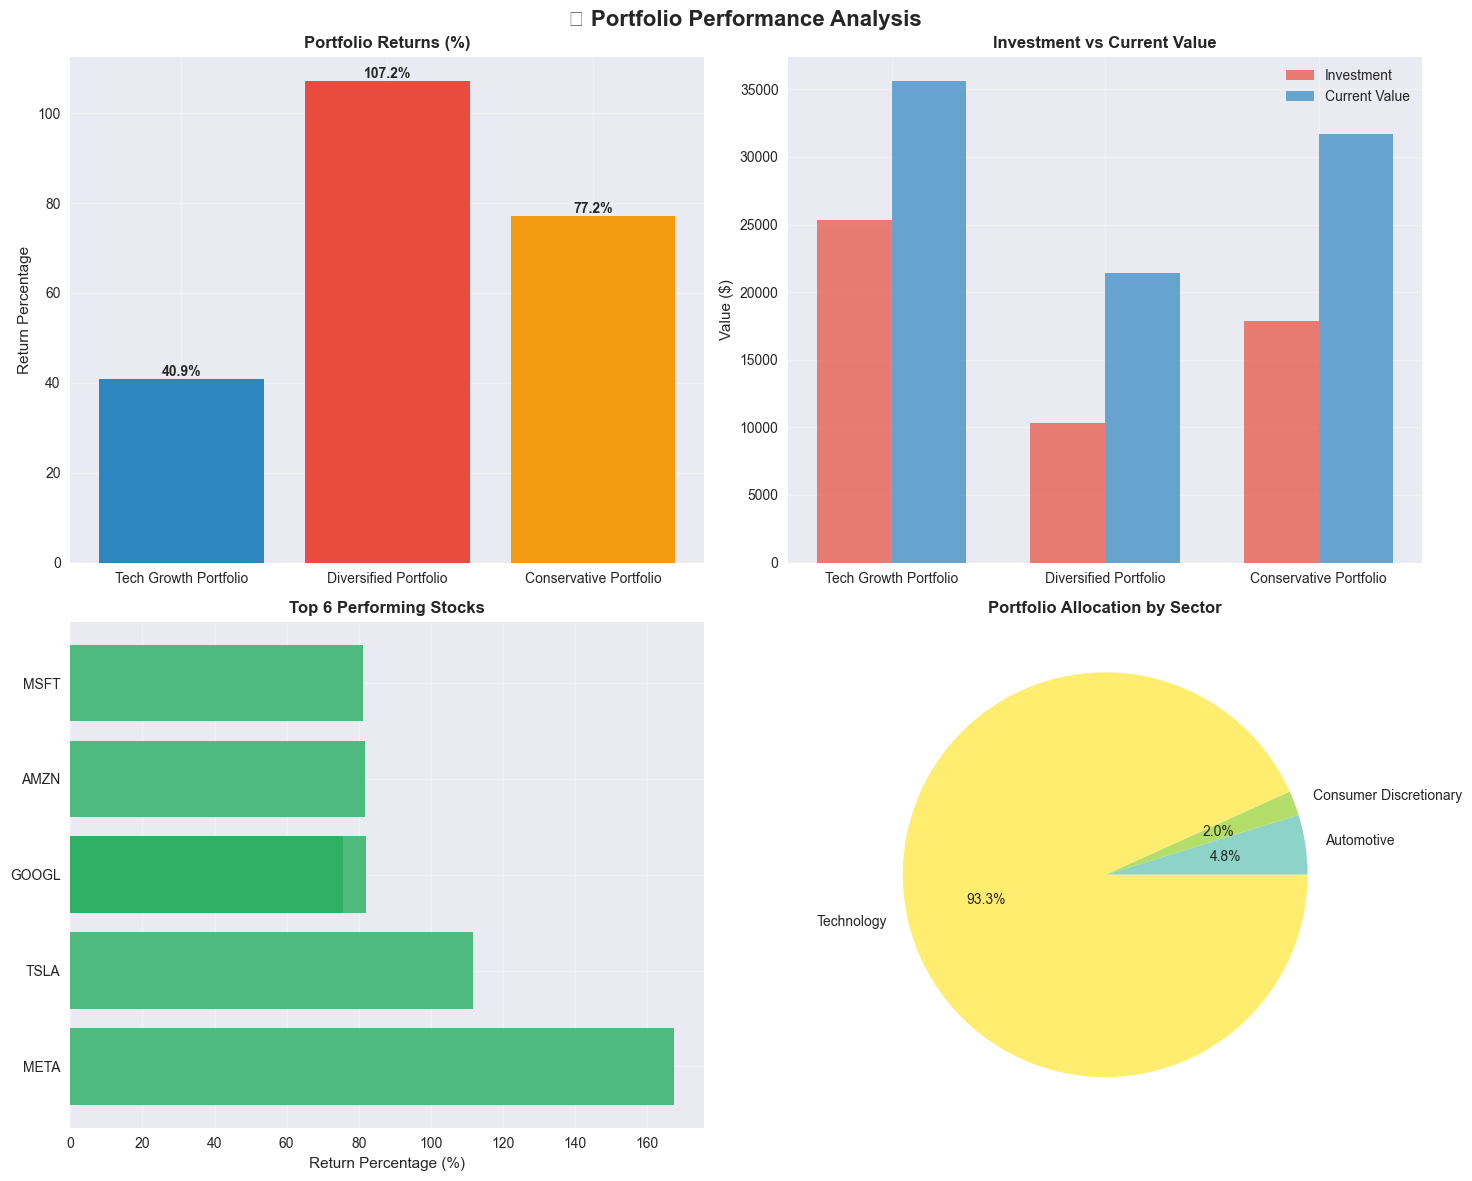

In [51]:
# Generate portfolio performance visualizations
analyzer.create_portfolio_performance_chart(portfolio_results)

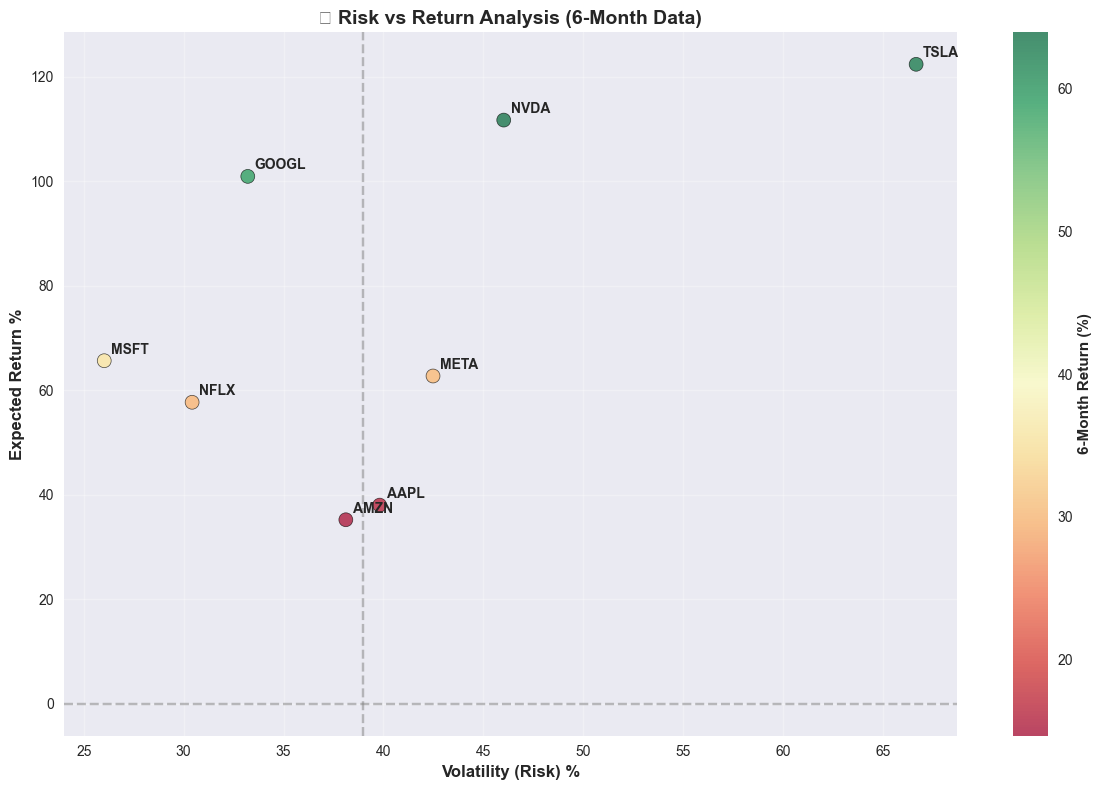

In [52]:
# Generate risk vs return scatter plot
analyzer.create_risk_return_analysis(risk_metrics)

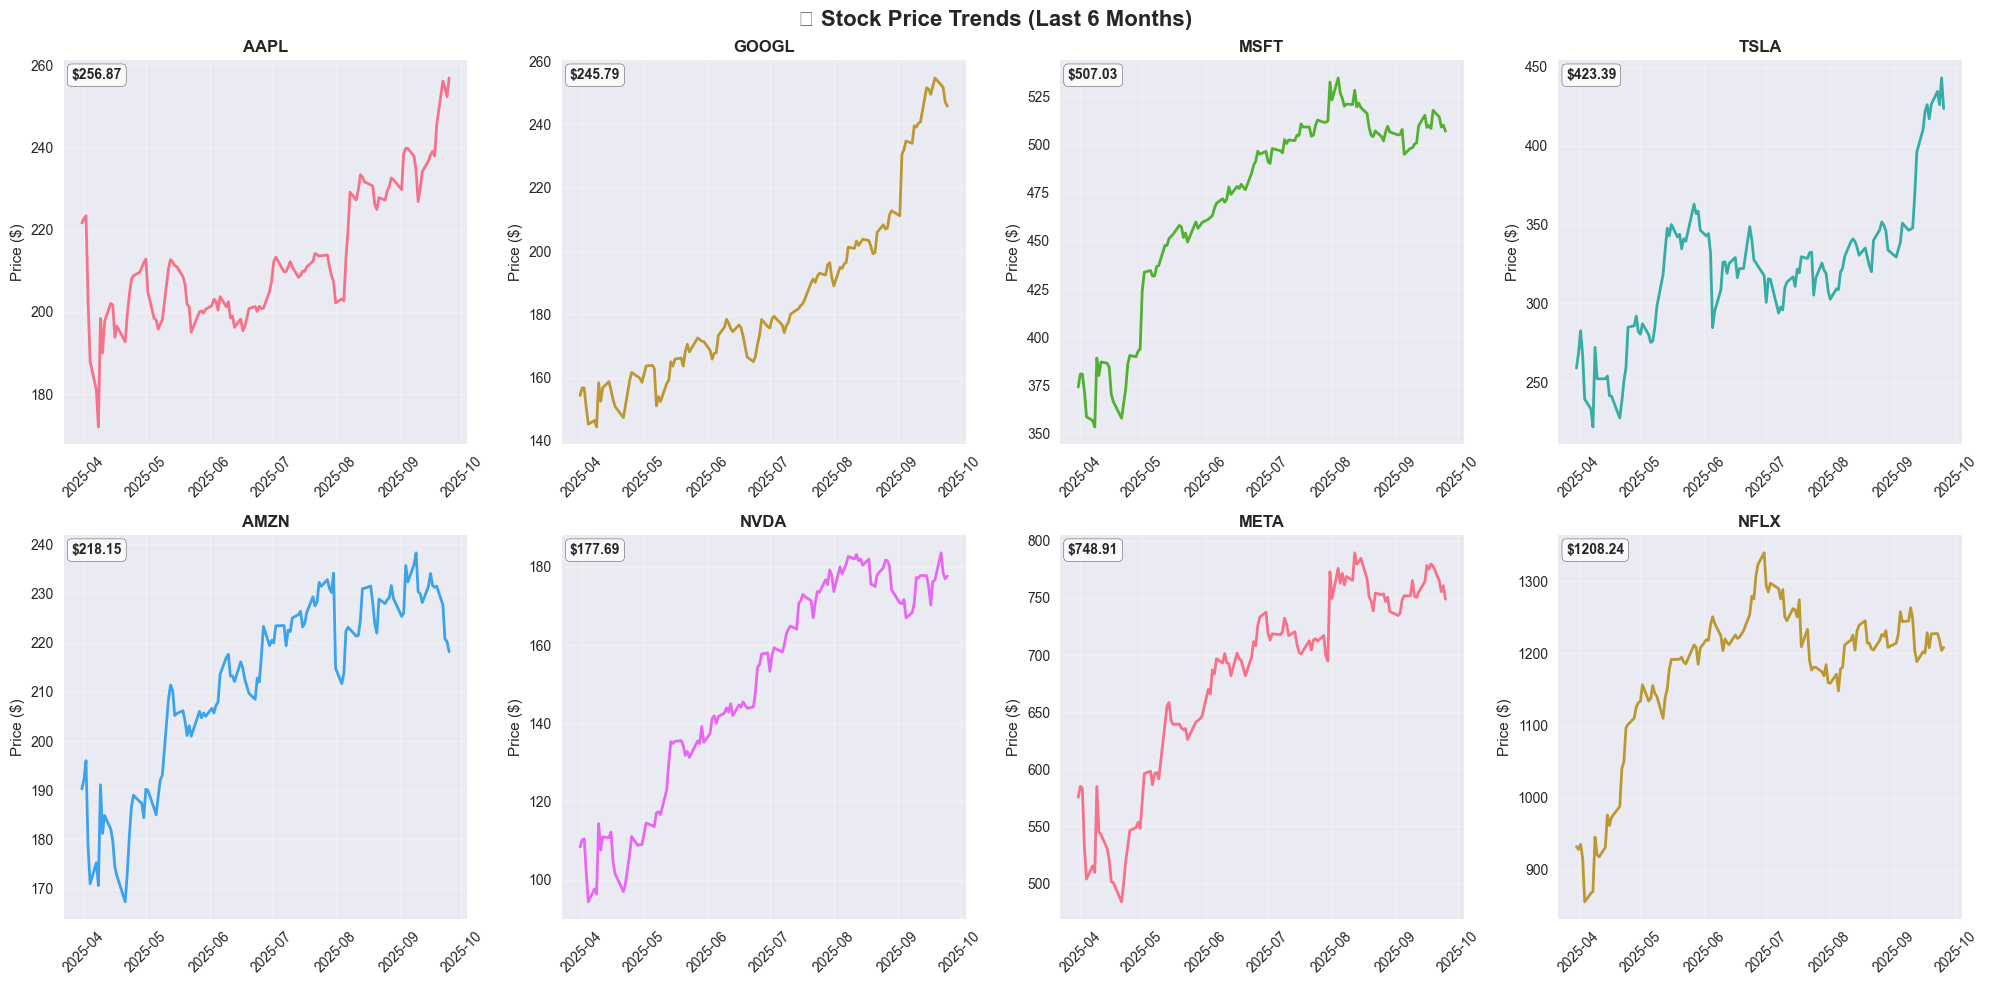

In [53]:
# Generate price trend analysis
analyzer.create_price_trends_analysis(stock_data)

In [48]:
# Generate comprehensive report
analyzer.generate_performance_report(portfolio_results, risk_metrics, alerts_data)

# Close connection
analyzer.close_connection()

📊 INVESTMENT PORTFOLIO ANALYSIS REPORT
📅 Generated on: 2025-09-26 03:46:29

📈 PORTFOLIO PERFORMANCE SUMMARY
--------------------------------------------------
Portfolio: Tech Growth Portfolio
  💰 Total Investment: $25,300.00
  📊 Current Value: $35,635.55
  💹 Total Return: $10,335.55 (40.85%)
  📋 Holdings: 4 stocks

Portfolio: Diversified Portfolio
  💰 Total Investment: $10,320.00
  📊 Current Value: $21,387.77
  💹 Total Return: $11,067.77 (107.25%)
  📋 Holdings: 4 stocks

Portfolio: Conservative Portfolio
  💰 Total Investment: $17,875.00
  📊 Current Value: $31,674.15
  💹 Total Return: $13,799.15 (77.20%)
  📋 Holdings: 3 stocks

⚠️ RISK ANALYSIS
--------------------------------------------------
Top 5 Highest Risk Stocks (by Volatility):
  TSLA: 66.7% volatility, 122.4% expected return
  NVDA: 46.0% volatility, 111.7% expected return
  META: 42.5% volatility, 62.7% expected return
  AAPL: 39.8% volatility, 38.0% expected return
  AMZN: 38.1% volatility, 35.2% expected return

Top 5 Best 